In [29]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../dmae/src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, Discriminator
import magic
import torch
import pathlib
import copy
from procrustes import Procrustes
import pickle
import graphtools
import scanpy as sc
from plotly3d.plot import scatter
from tqdm import tqdm

In [30]:
wandb.login()
api = wandb.Api()

In [31]:
folder_path = '../../src/wandb/'
entity = "xingzhis"
project = "dmae"

In [32]:
run_id = "mhzzbpj5" # gaussian
run = api.run(f"{entity}/{project}/{run_id}")
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
# data_path2 = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
# data = np.load(data_path2, allow_pickle=True)

model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"./{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)

with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    # x = torch.tensor(X, dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(torch.tensor(z))
    z = z.cpu().numpy()
    xh = xh.cpu().numpy()

proc = Procrustes()
p1, z1, di = proc.fit_transform(data['phate'], z)


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
/tmp/ipykernel_483471/1737278247.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xh = model.decoder(torch.tensor(z))


/tmp/ipykernel_483471/3579983702.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


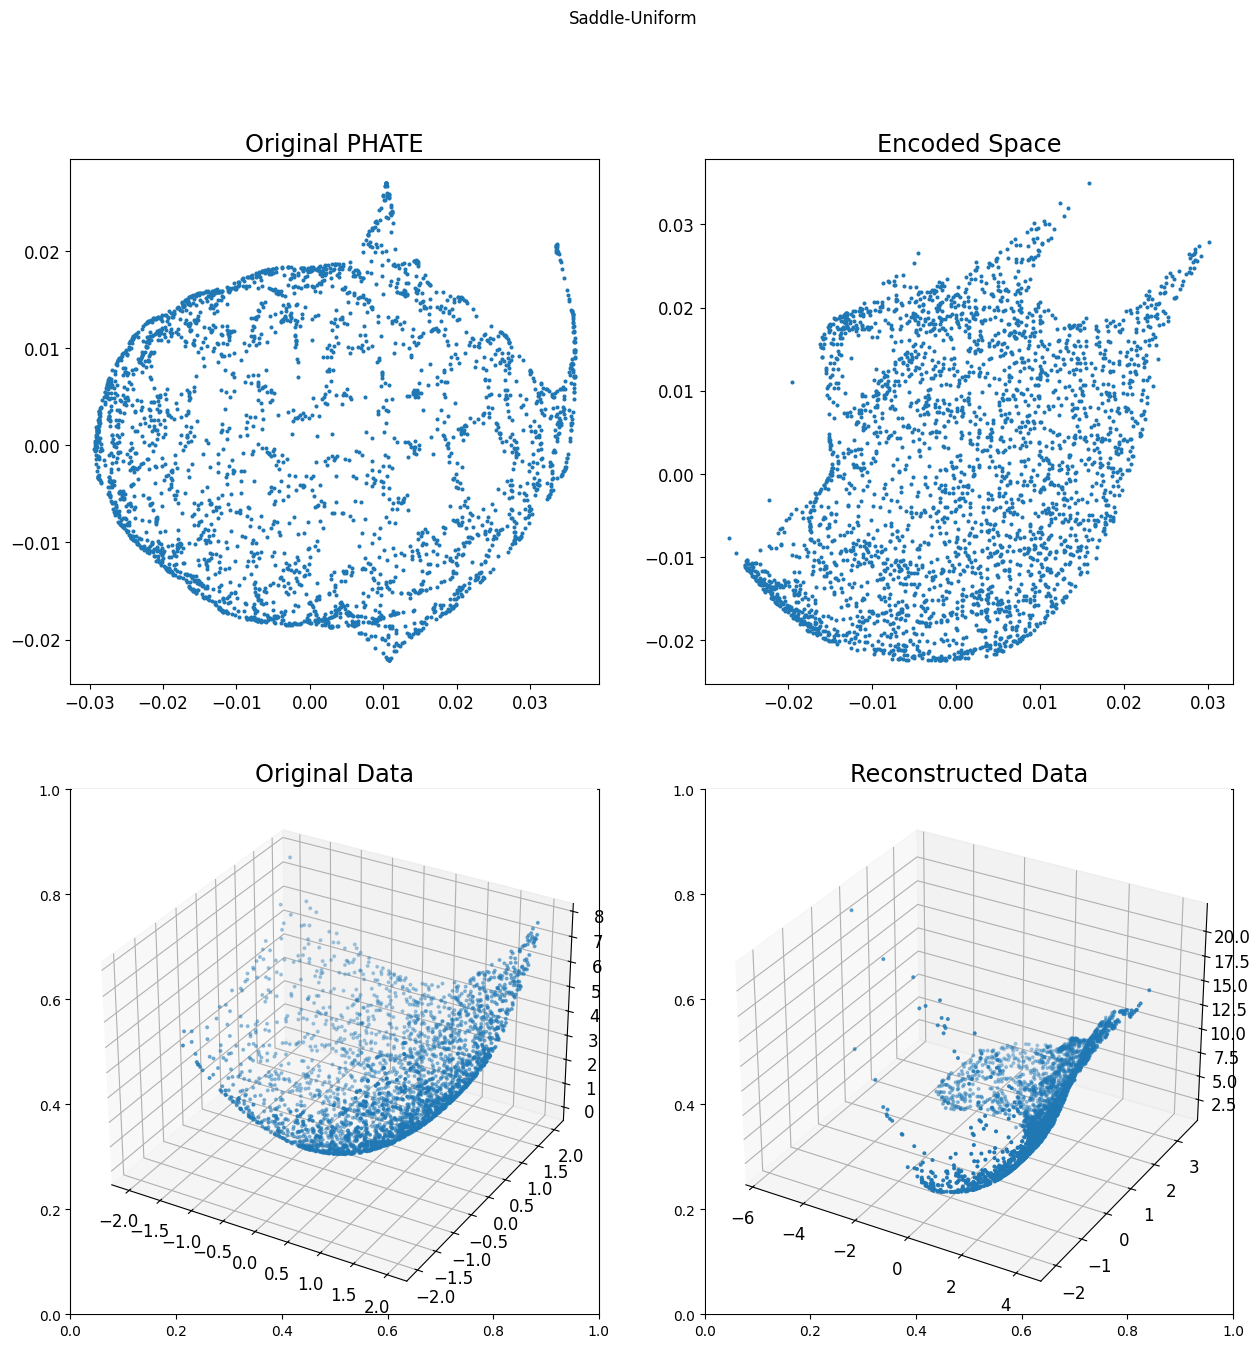

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

scprep.plot.scatter2d(data['phate'], ax=axs[0, 0], title='Original PHATE')
scprep.plot.scatter2d(z1, ax=axs[0, 1], title='Encoded Space')

ax1 = fig.add_subplot(223, projection='3d')
scprep.plot.scatter3d(data['data'], ax=ax1, title='Original Data')

ax2 = fig.add_subplot(224, projection='3d')
scprep.plot.scatter3d(xh, ax=ax2, title='Reconstructed Data')

plt.suptitle('Saddle-Uniform')
plt.tight_layout()
plt.show()

In [34]:
from geodesic import jacobian

In [35]:
jac = jacobian(model.encoder, x)

In [36]:
U, S, Vh = torch.linalg.svd(jac, full_matrices=False)

In [37]:
S.shape

torch.Size([3000, 2])

In [38]:
vol_elem = S.prod(axis=1)

In [39]:
def area_element(u, v):
    """
    Computes the area element for the paraboloid surface.
    """
    E = 1 + (2 * u)**2  # E = 1 + 4u^2
    F = (2 * u) * (2 * v)  # F = 4uv
    G = 1 + (2 * v)**2  # G = 1 + 4v^2
    dA = np.sqrt(E * G - F**2)
    return dA

def area_element_torch(u, v):
    """
    Computes the area element for the paraboloid surface using PyTorch.
    """
    E = 1 + (2 * u)**2  # E = 1 + 4u^2
    F = (2 * u) * (2 * v)  # F = 4uv
    G = 1 + (2 * v)**2  # G = 1 + 4v^2
    dA = torch.sqrt(E * G - F**2)
    return dA

In [40]:
vol_elem_analycial = area_element_torch(x[:, 0], x[:, 1])

In [41]:
vol_elem_analycial

tensor([2.9274, 2.2578, 2.4168,  ..., 3.2124, 2.6239, 2.2676])

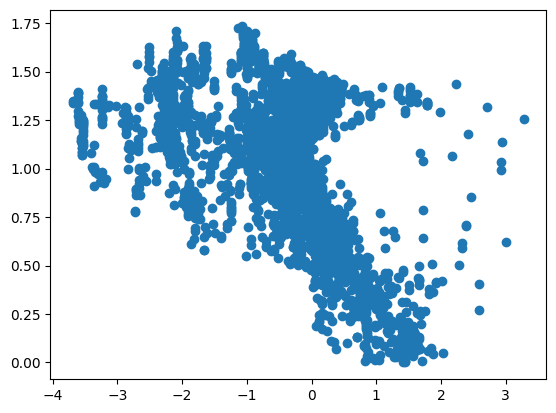

In [42]:
plt.scatter(torch.log(vol_elem).detach().numpy(), torch.log(vol_elem_analycial).detach().numpy())

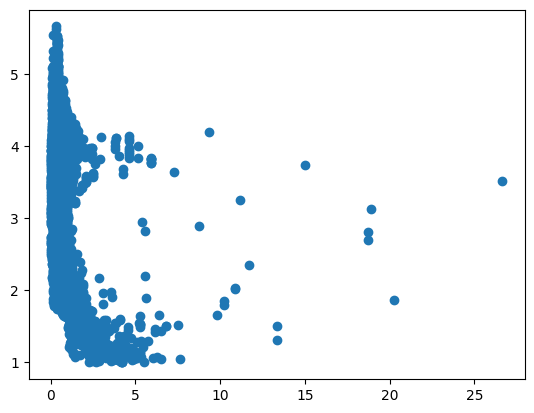

In [43]:
plt.scatter((vol_elem).detach().numpy(), (vol_elem_analycial).detach().numpy())

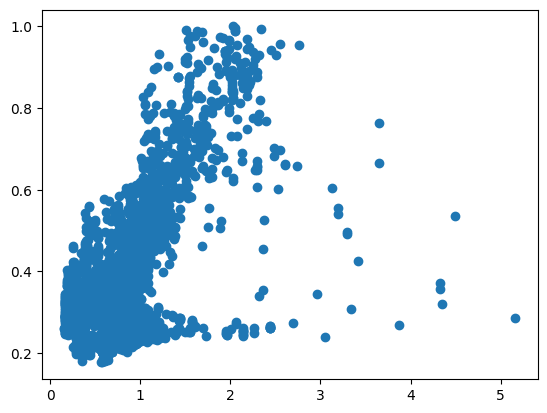

In [44]:
plt.scatter(torch.sqrt(vol_elem).detach().numpy(), 1/(vol_elem_analycial).detach().numpy())

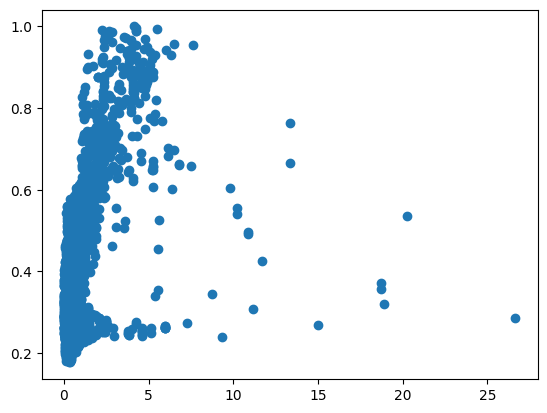

In [45]:
plt.scatter((vol_elem).detach().numpy(), 1/(vol_elem_analycial).detach().numpy())


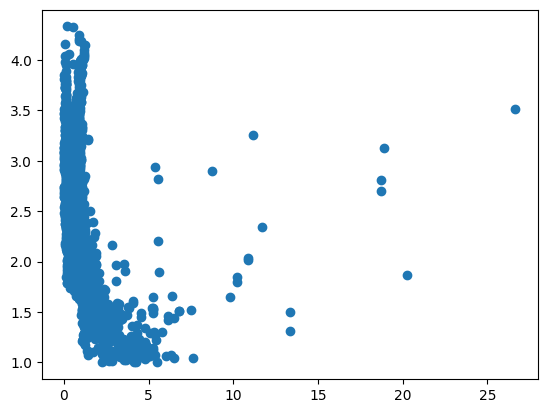

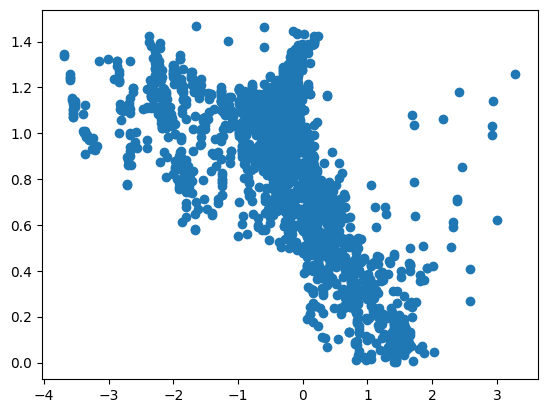

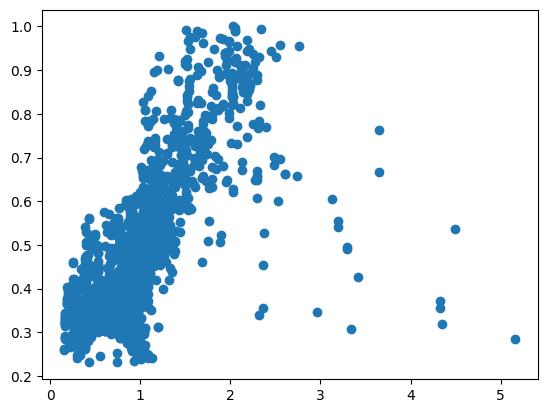

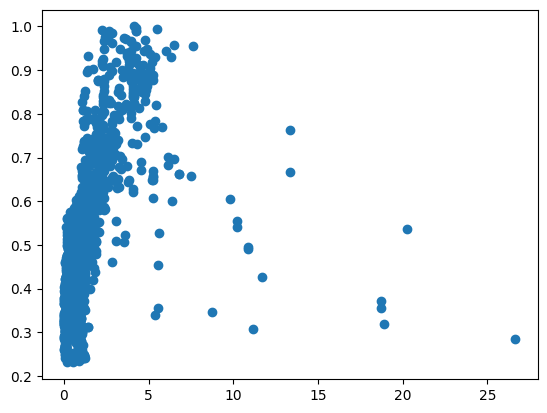

In [46]:
no_margin_mask = (x[:,0]>-1.5) & (x[:,0]<1.5) & (x[:,1]>-1.5) & (x[:,1]<1.5)
plt.scatter((vol_elem).detach().numpy()[no_margin_mask], (vol_elem_analycial).detach().numpy()[no_margin_mask])
plt.show()
plt.scatter(torch.log(vol_elem).detach().numpy()[no_margin_mask], torch.log(vol_elem_analycial).detach().numpy()[no_margin_mask])
plt.show()
plt.scatter(torch.sqrt(vol_elem).detach().numpy()[no_margin_mask], 1/(vol_elem_analycial).detach().numpy()[no_margin_mask])
plt.show()
plt.scatter((vol_elem).detach().numpy()[no_margin_mask], 1/(vol_elem_analycial).detach().numpy()[no_margin_mask])
plt.show()

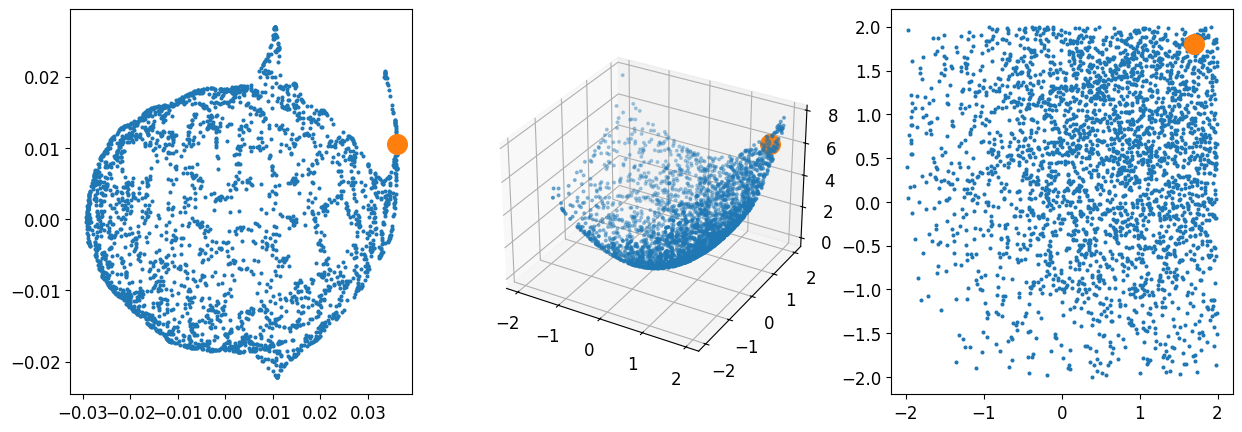

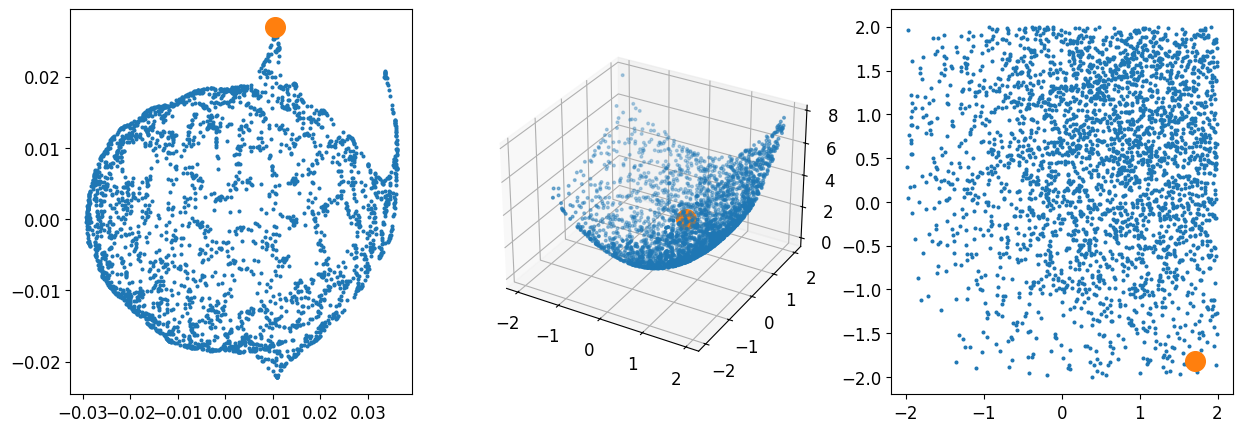

In [47]:
i = np.argmax(data['phate'][:,0])
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
scprep.plot.scatter2d(data['phate'], ax=ax)
scprep.plot.scatter2d(data['phate'][i], ax=ax)
ax = fig.add_subplot(132, projection='3d')
scprep.plot.scatter3d(x.detach().numpy(), ax=ax)
scprep.plot.scatter3d(x[i].detach().numpy(), ax=ax)
ax = fig.add_subplot(133)
scprep.plot.scatter2d(x.detach().numpy(), ax=ax)
scprep.plot.scatter2d(x[i].detach().numpy(), ax=ax)
plt.show()
i = np.argmax(data['phate'][:,1])
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
scprep.plot.scatter2d(data['phate'], ax=ax)
scprep.plot.scatter2d(data['phate'][i], ax=ax)
ax = fig.add_subplot(132, projection='3d')
scprep.plot.scatter3d(x.detach().numpy(), ax=ax)
scprep.plot.scatter3d(x[i].detach().numpy(), ax=ax)
ax = fig.add_subplot(133)
scprep.plot.scatter2d(x.detach().numpy(), ax=ax)
scprep.plot.scatter2d(x[i].detach().numpy(), ax=ax)
plt.show()